# Figure 4: Radiation Biases with CERES-EBAF and cloud biases

### Add paths to run locally or off NIRD

In [4]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax, align_yaxis
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

### Check running location and adjust working directory appropriately.

In [5]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## Load data into metric classes

In [6]:
allcases = SatComp_Metric(case_dir)

allcases.add_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1', label="CAM6-Oslo")
allcases.add_case('CESM2_slfvars', label="CAM6")
allcases.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1', label="CAM6-OsloIce")

allcases.add_case("20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10",label='CAM6-Oslo \n Fit 1')
# allcases.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',label='CAM6-OsloIce \n Fit 2')
allcases.add_case('20200629_morn_cam61satcomp_wbf_0.5_inp_0.05',label='CAM6-OsloIce \n Fit 2')
allcases.add_case('20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1',label='CAM6-OsloIce \n Fit 3')
allcases.add_case('20200713_CESM2_satcomp_wbf_1_inp_100',label="CAM6 \n Fit 4")

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.
Trying to load concatenated file for 20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1
20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for CESM2_slfvars
CESM2_slfvars load successfully.
Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1
20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10
20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10 load successfully.
Trying to load concatenated file for 20200629_morn_cam61satcomp_wbf_0.5_inp_0.05
20200629_morn_cam61satcomp_wbf_0.5_inp_0.05 load successfully.
Trying to load concatenated file for 20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1
20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1 load successfully.
Trying to load

## Plot the stuff

Text(0.55,0.42,'d.')

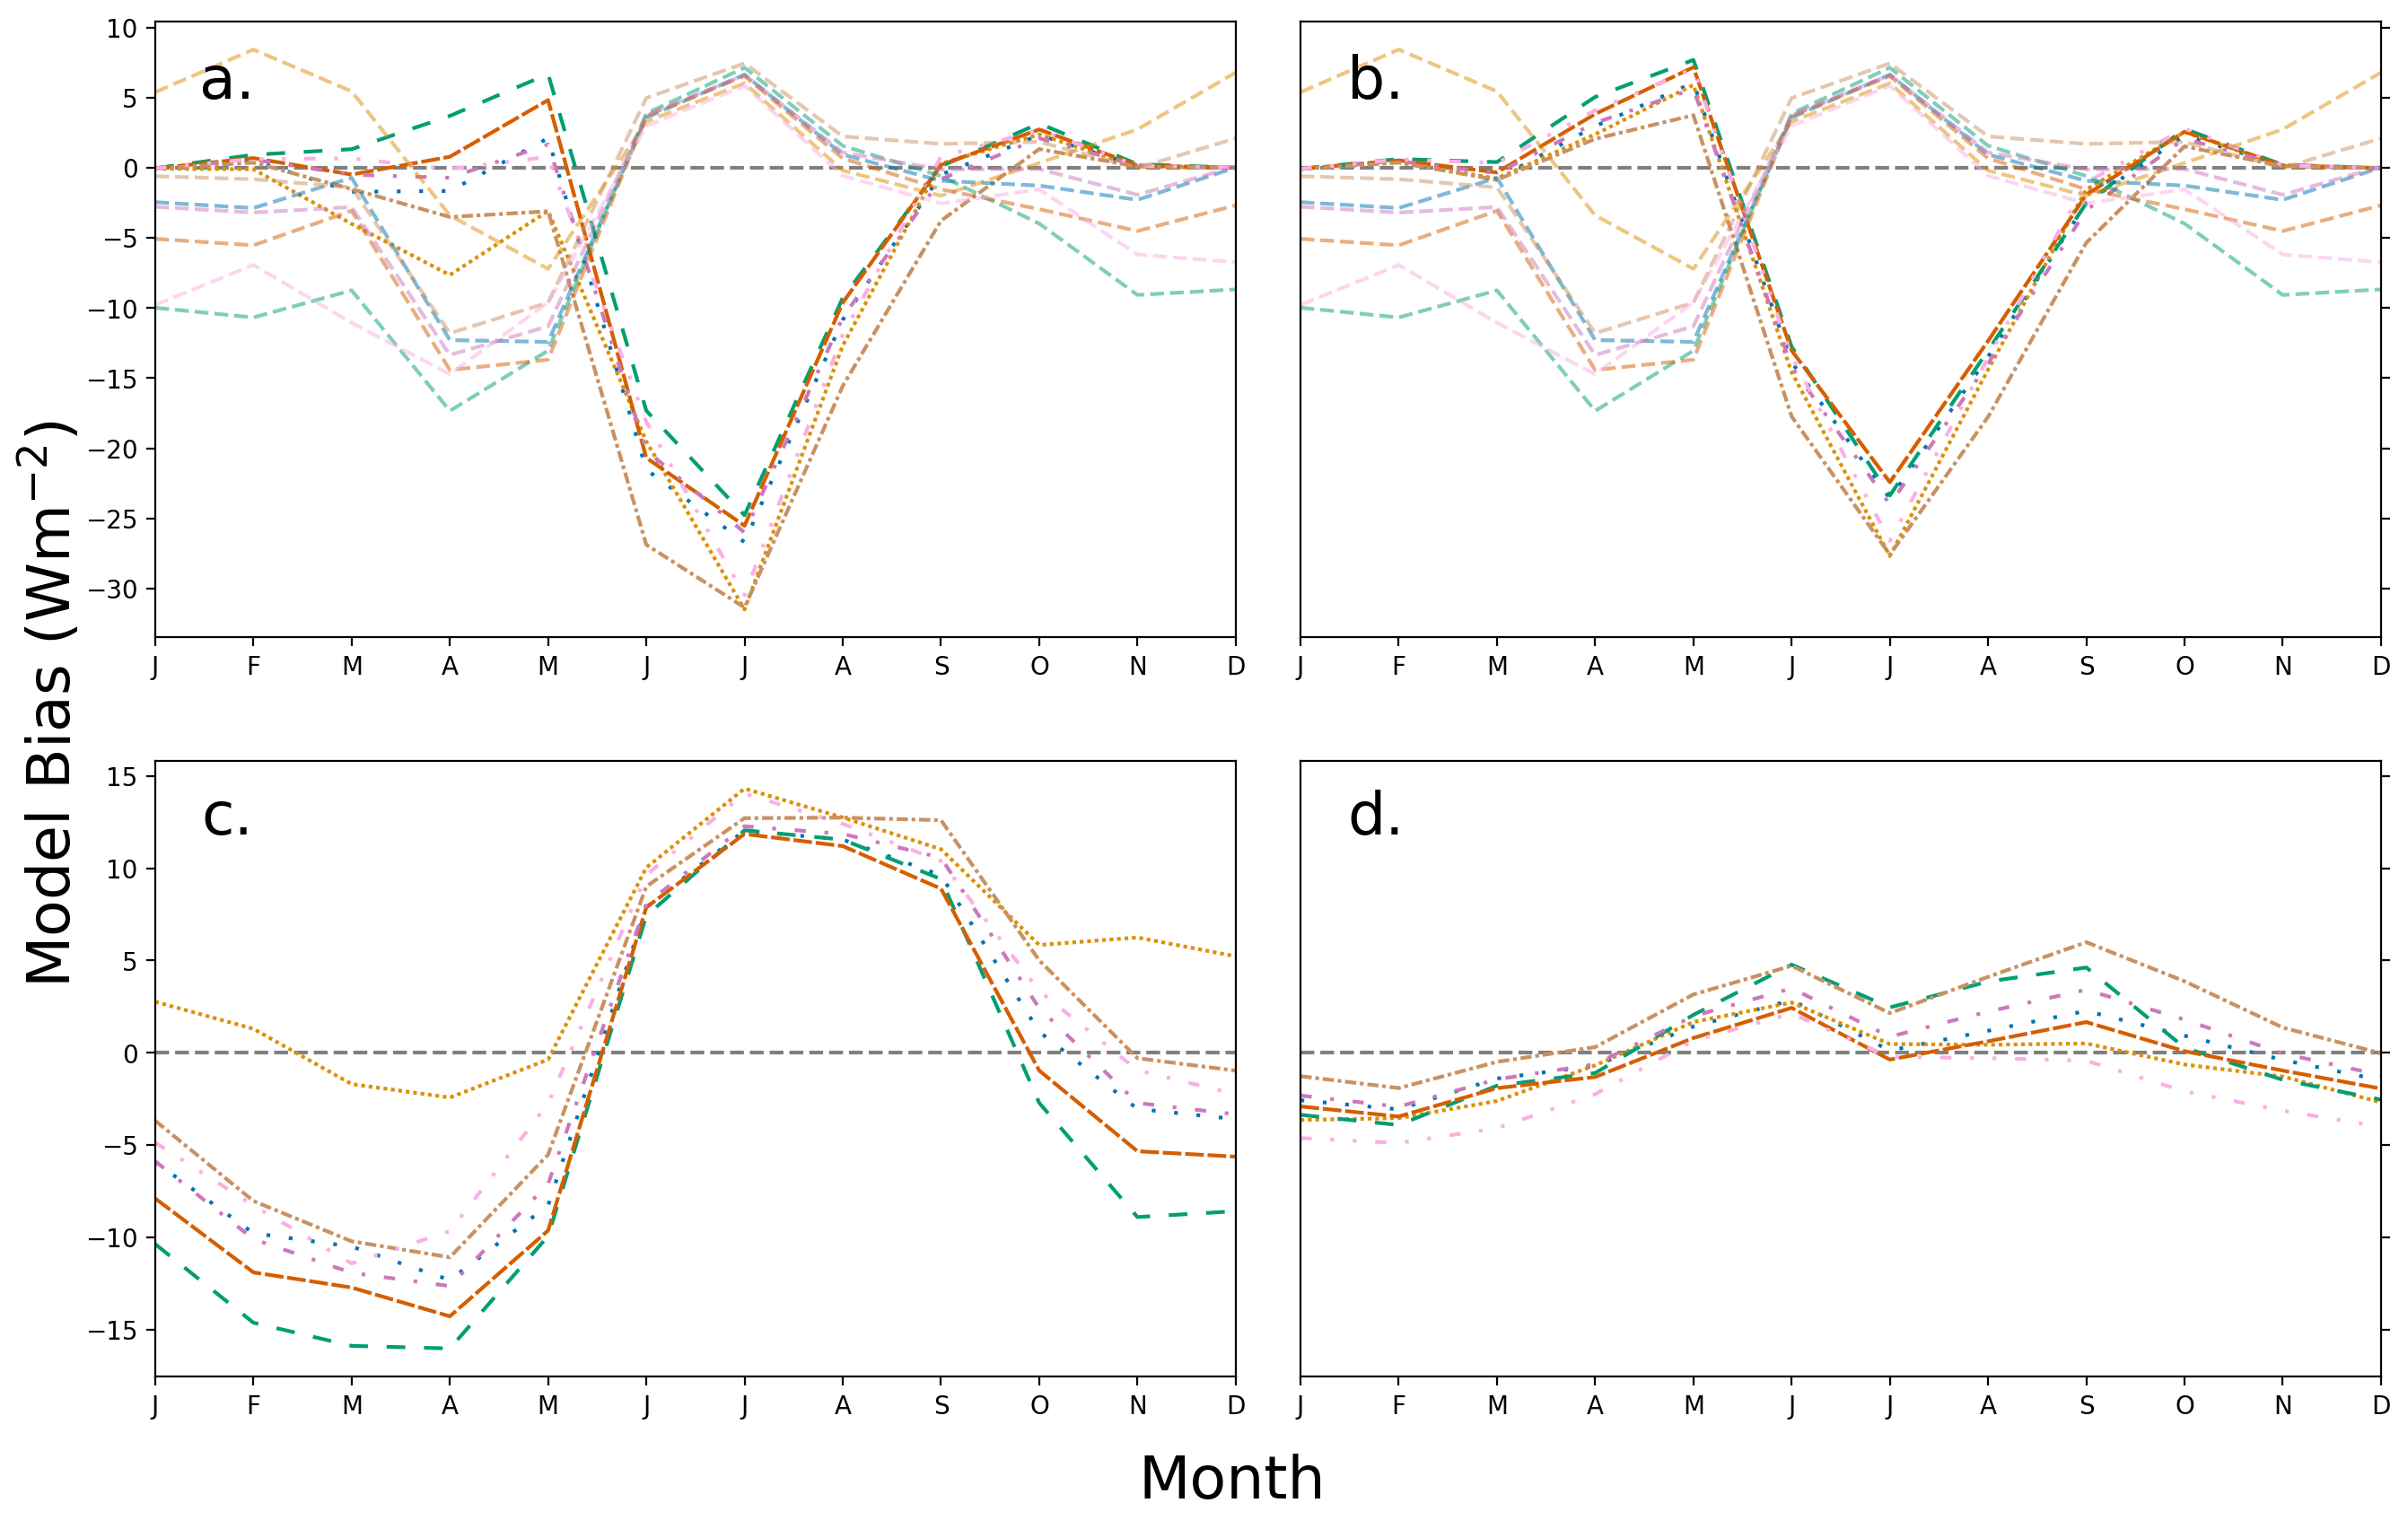

In [9]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(16)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

allcases.plot_months_line('FSDS',ax=axs[0], bias=True)
allcases.plot_months_line('SWCF',ax=axs[1], bias=True)
allcases.plot_months_line('FLDS',ax=axs[2], bias=True)
allcases.plot_months_line('LWCF',ax=axs[3], bias=True)

allcases.plot_months_line('CLDTOT_CAL',ax=axs[0], bias=True, linestyle='dashed',alpha=0.5)
allcases.plot_months_line('CLDTOT_CAL',ax=axs[1], bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL_LIQ',ax=axs[2], bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL',ax=axs[3], bias=True, linestyle='dashed',alpha=0.5)

# Mute existing labels and draw zero lines
for i in axs:
    mute_ax(i)
    i.hlines(0,1,12, linestyle='dashed',color='gray')
    i.set_xlim(1,12)

# Janky share yaxis so I can have more ticks:
# _min,_max = np.max([axs[0].get_ylim(),axs[1].get_ylim()])
axs[1].yaxis.tick_right()
# axs[1].set_ylim(axs[0].get_ylim())
axs[3].yaxis.tick_right()
# axs[3].set_ylim(axs[2].get_ylim())
    
# Mute legends after the first
# fig.axes[-1].legend().set_visible(False)
# fig.axes[-2].legend().set_visible(False)
# fig.axes[-3].legend().set_visible(False)
 
# axs[1].set_yticklabels([])

# Trying Latex formatting
# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

# Re-label
fig.text(0.1, 0.5, r'Model Bias (Wm$^{-2}$)', va='bottom', ha='center', rotation='vertical', 
         rotation_mode='anchor', fontsize=24)
# fig.text(0.93, 0.7, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=18)
# fig.text(0.93, 0.5, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=22)
fig.text(0.5, 0.05, 'Month', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.42, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.42, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

Text(0.55,0.42,'d.')

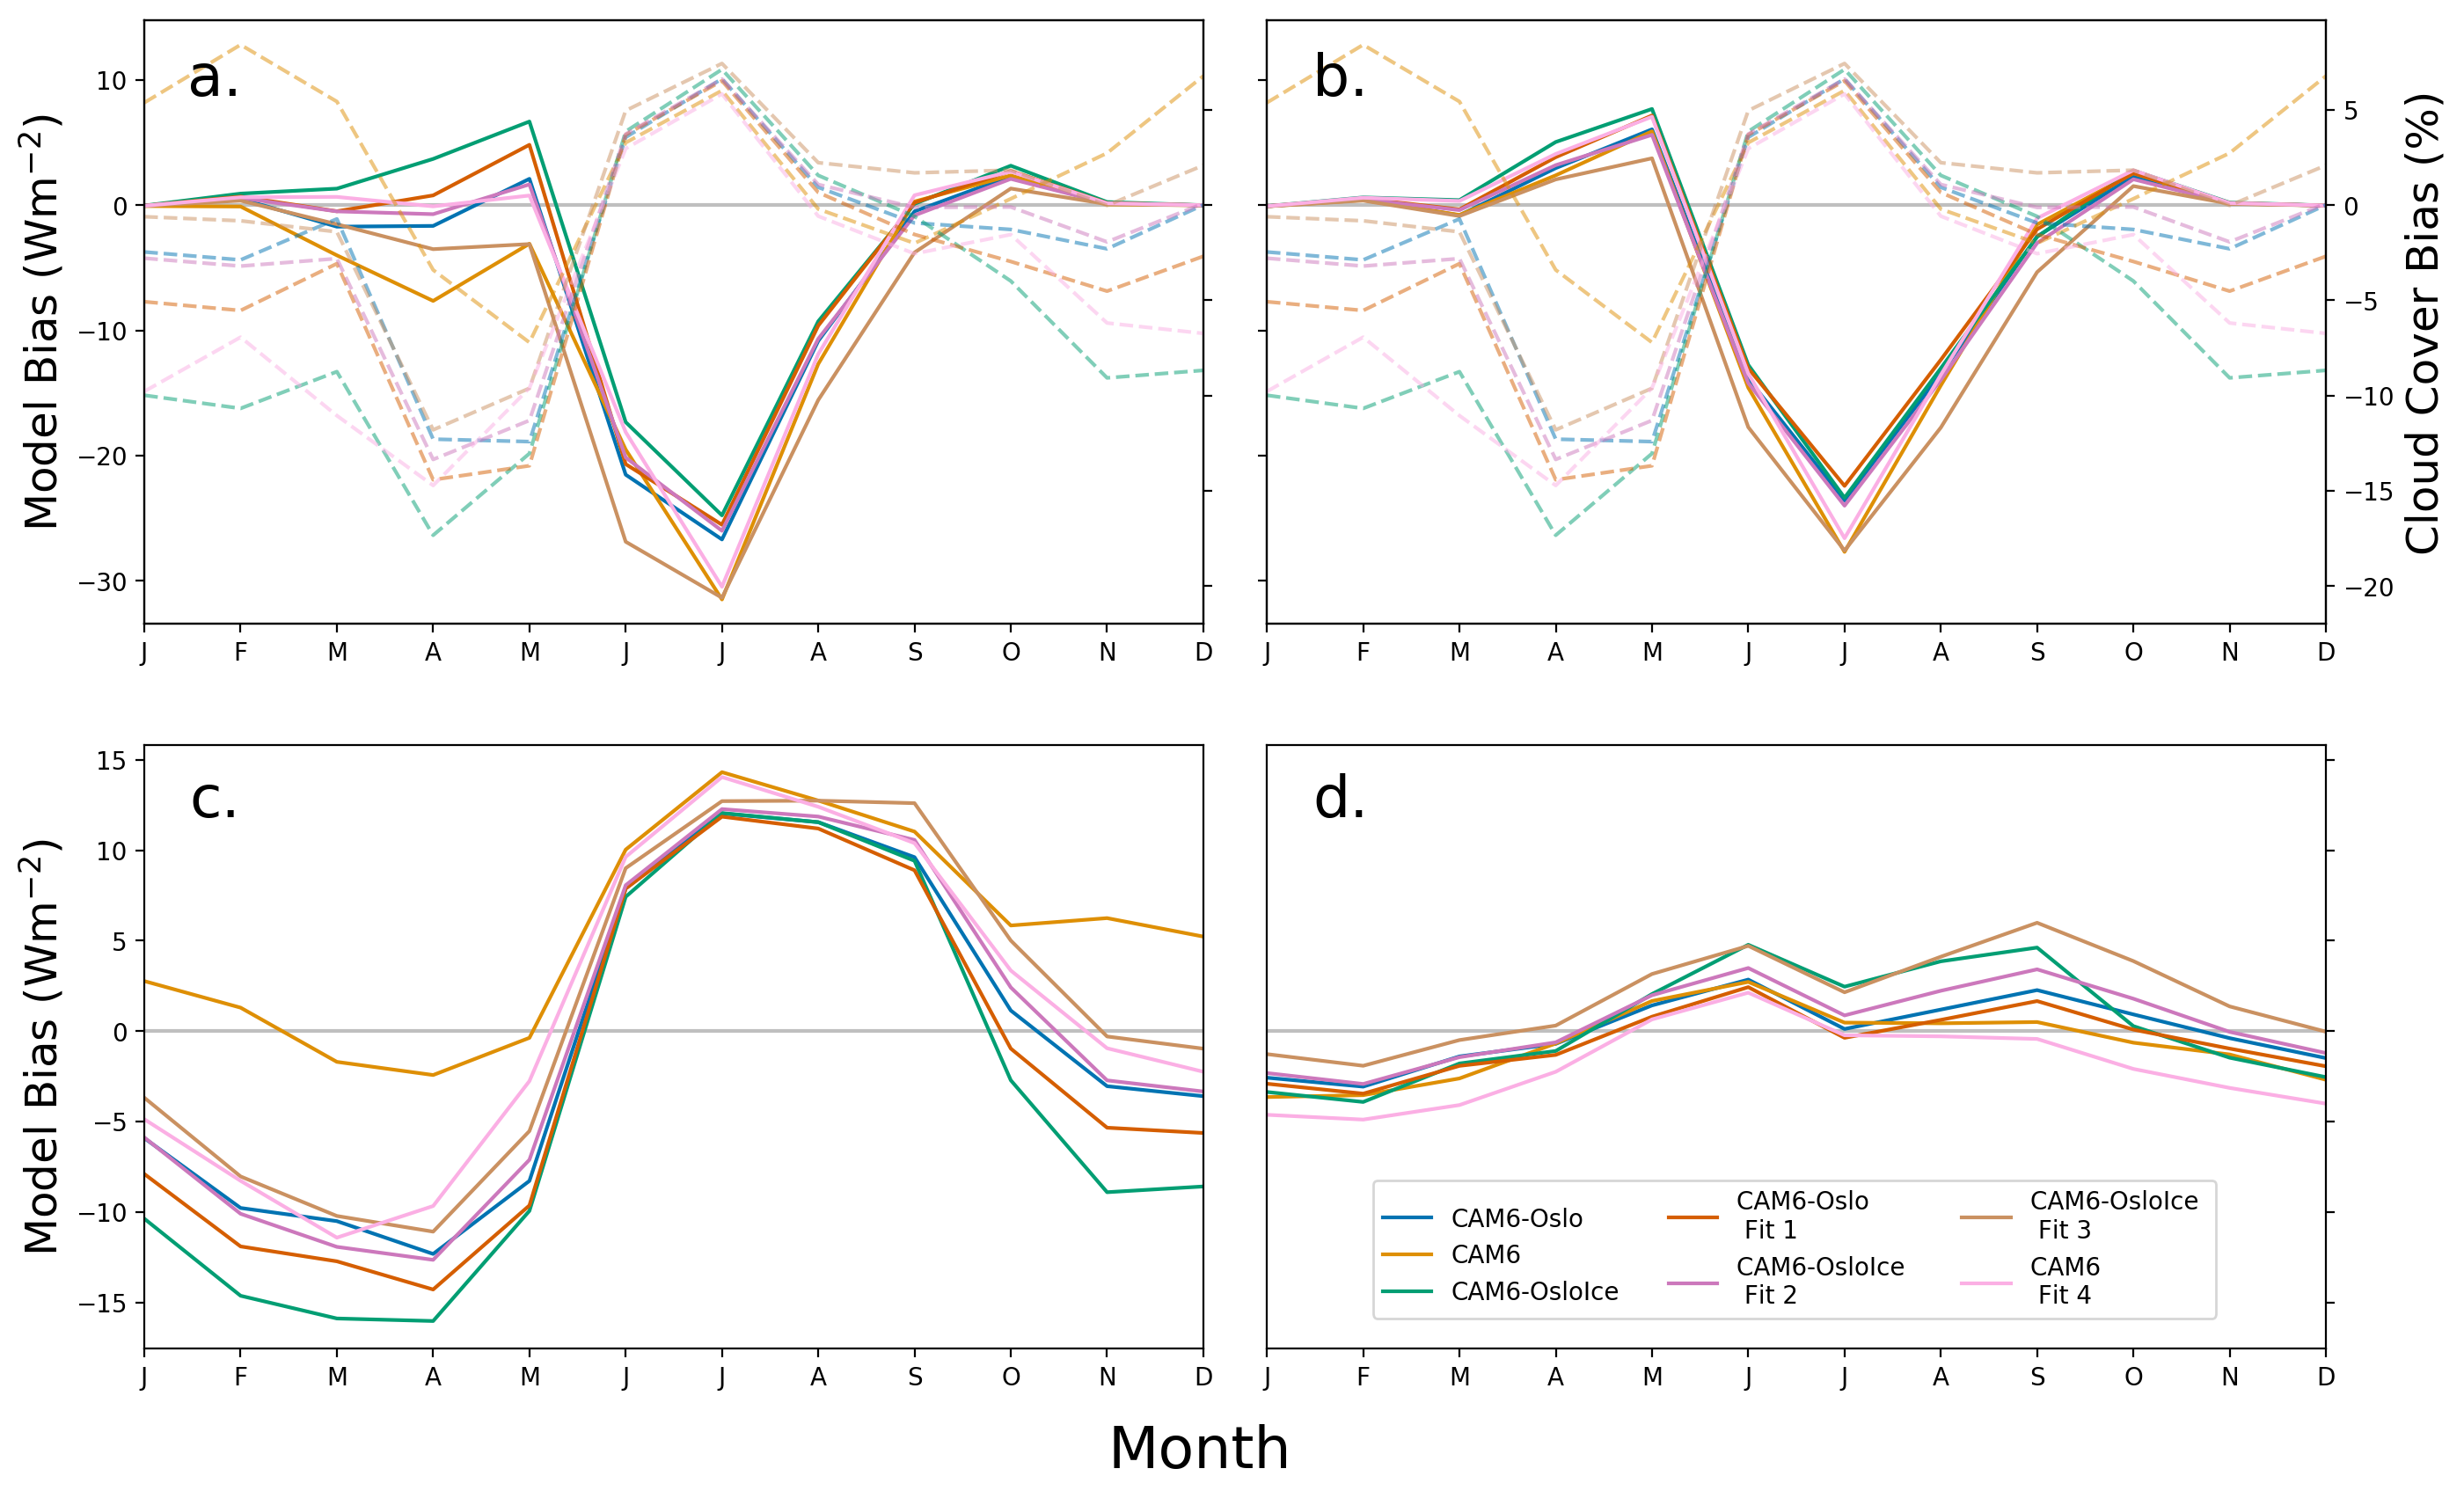

In [4]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(16)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

allcases.plot_months_line('FSDS',ax=axs[0], bias=True,linestyle='solid')
allcases.plot_months_line('SWCF',ax=axs[1], bias=True,linestyle='solid')
allcases.plot_months_line('FLDS',ax=axs[2], bias=True,linestyle='solid')
allcases.plot_months_line('LWCF',ax=axs[3], bias=True,linestyle='solid')

ax0b = axs[0].twinx()
ax1b = axs[1].twinx()
allcases.plot_months_line('CLDTOT_CAL',ax=ax0b, bias=True, linestyle='dashed',alpha=0.5)
allcases.plot_months_line('CLDTOT_CAL',ax=ax1b, bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL_LIQ',ax=axs[2], bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL',ax=axs[3], bias=True, linestyle='dashed',alpha=0.5)

# Mute existing labels and draw zero lines
for i in axs:
    mute_ax(i)
    i.hlines(0,1,12, linestyle='solid',color='gray',alpha=0.5)
    i.set_xlim(1,12)
mute_ax(ax0b)
ax0b.set_yticklabels([])
mute_ax(ax1b)
# One legend
# axs[3].legend(loc='best',ncol=3)
axs[3].legend(loc=(0.1,0.05),ncol=3)

axs[0].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
ax1b.set_ylabel(r'Cloud Cover Bias (%)',fontsize=18)
axs[2].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
axs[3].yaxis.tick_right()

align_yaxis(axs[1], ax0b)
ax1b.set_ylim(ax0b.get_ylim())
# Trying Latex formatting
# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

# Re-label
# fig.text(0.1, 0.5, r'Model Bias (Wm$^{-2}$)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.95, 0.7, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=18)
# fig.text(0.93, 0.5, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=22)
fig.text(0.5, 0.05, 'Month', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.42, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.42, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

In [25]:
to_png(fig,'rad_biases3')

Text(0.55,0.42,'d.')

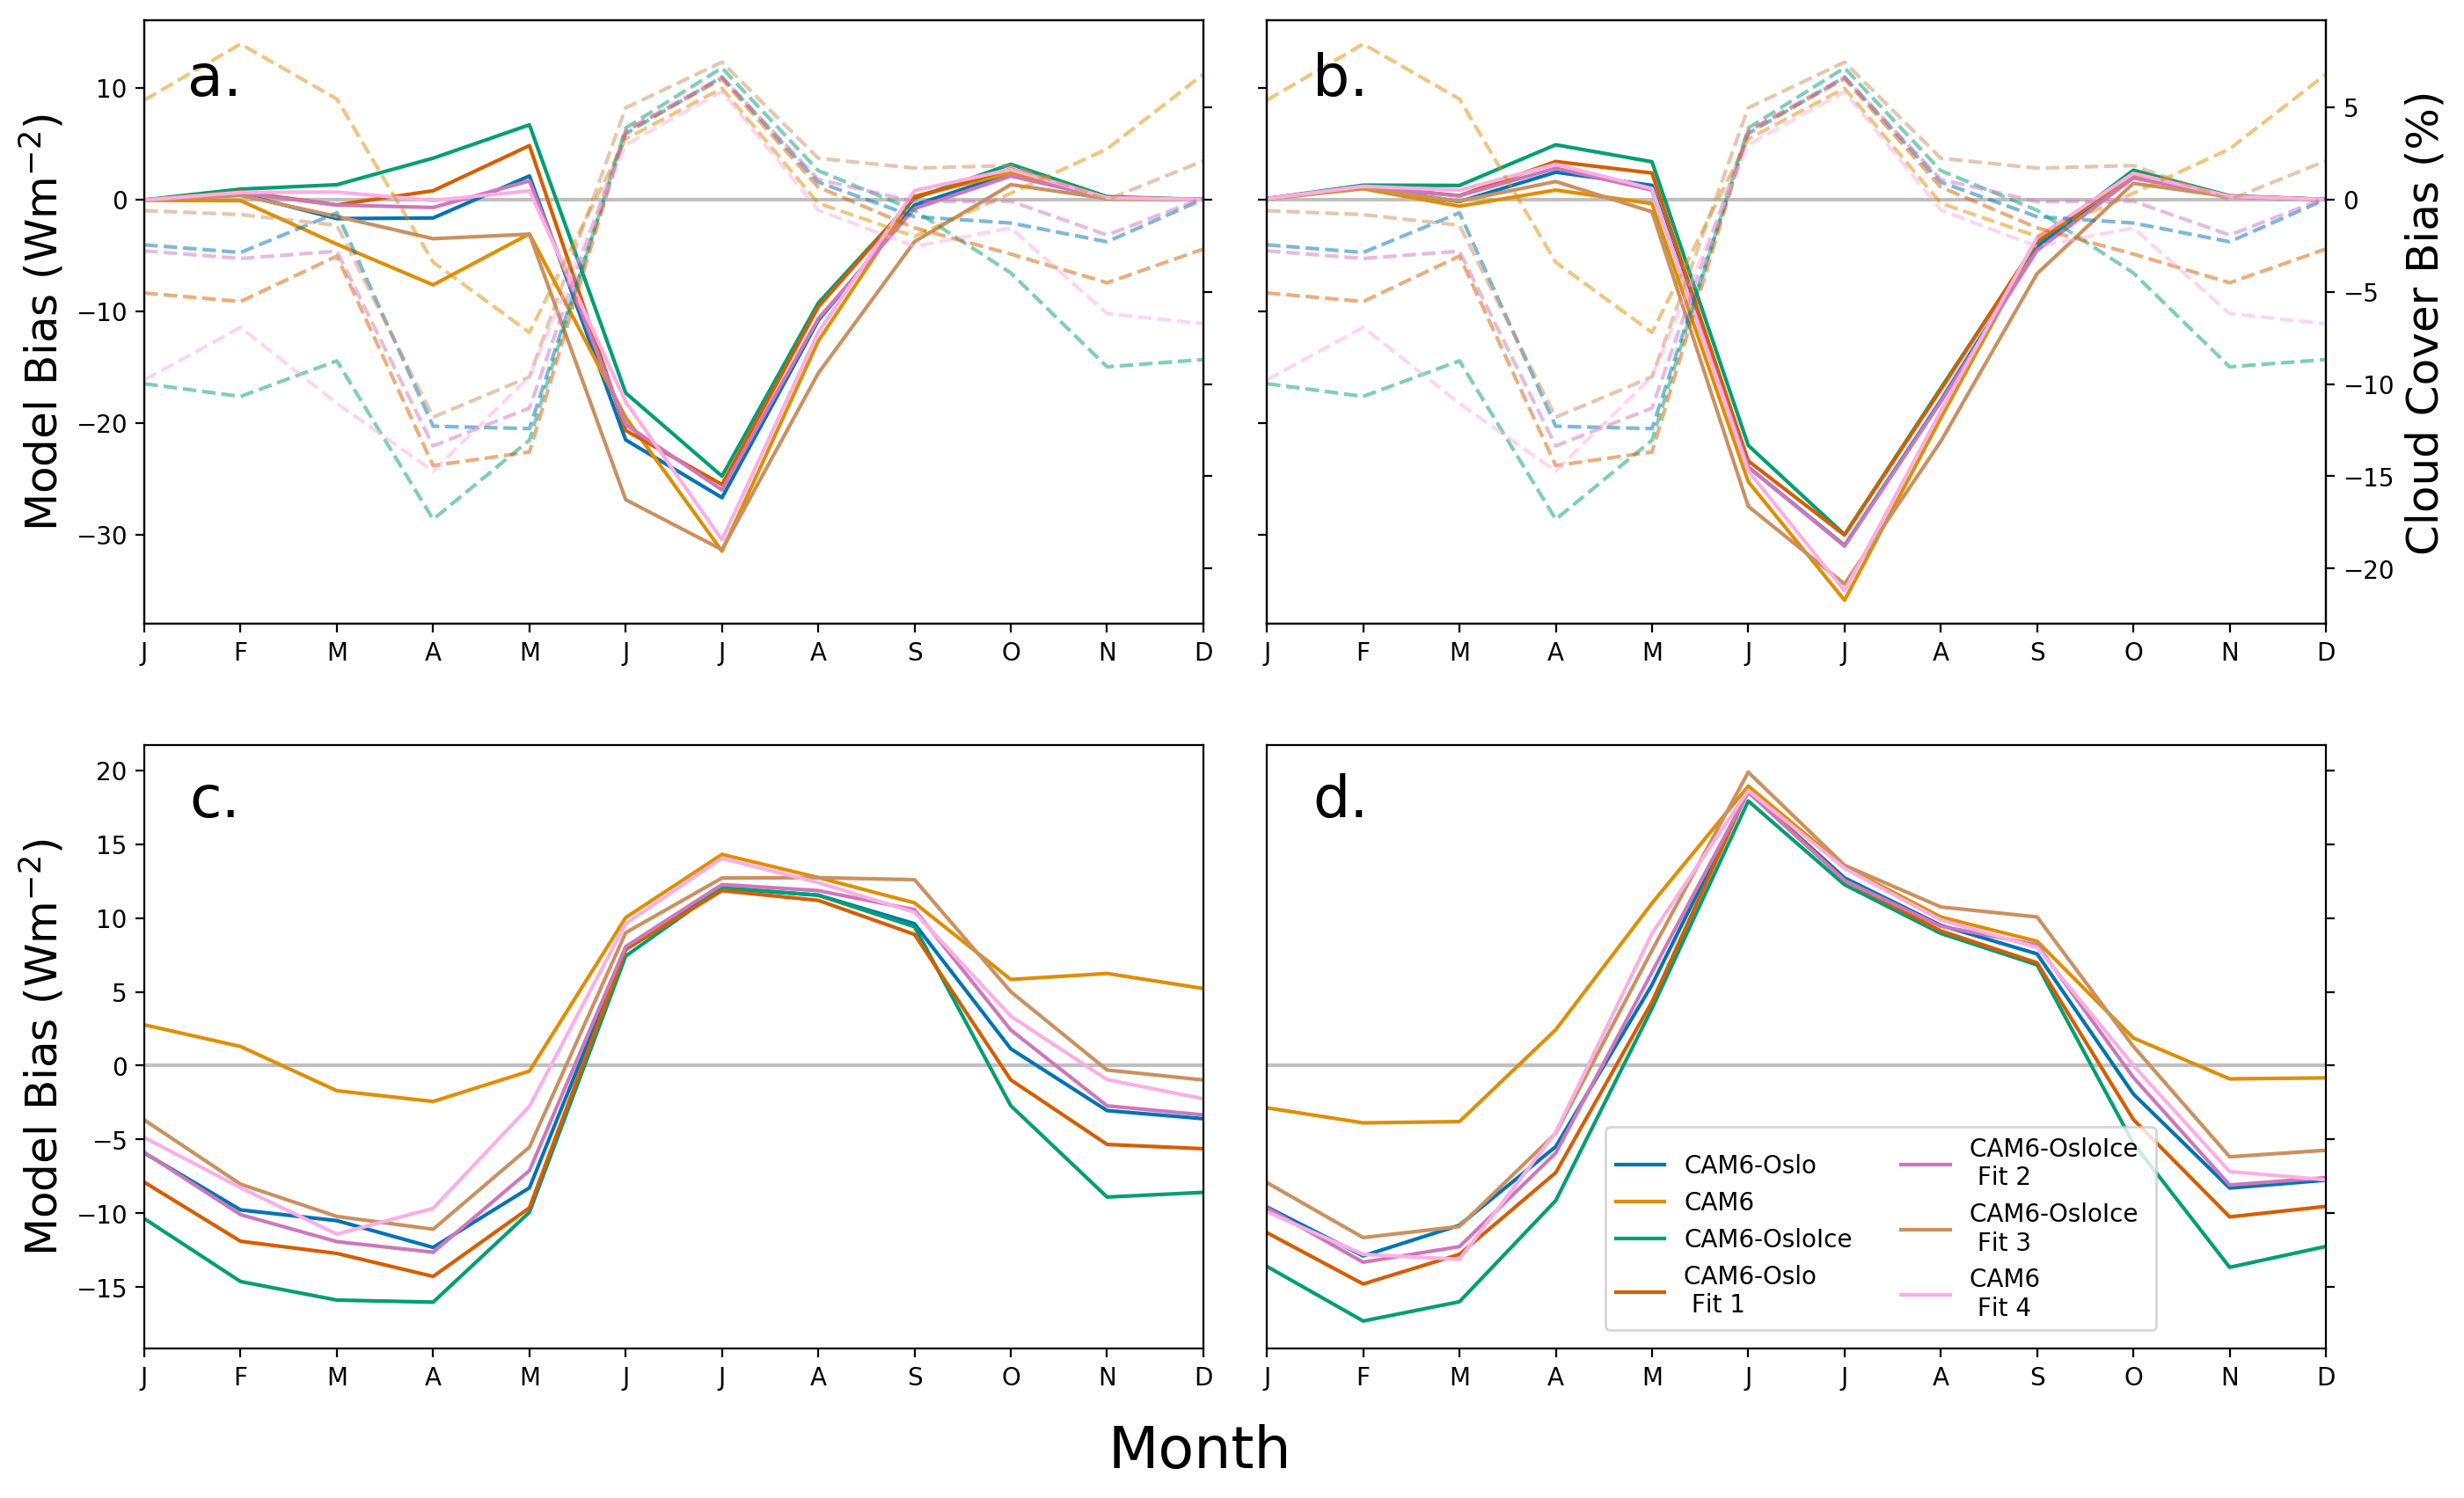

In [20]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(16)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

allcases.plot_months_line('FSDS',ax=axs[0], bias=True,linestyle='solid')
allcases.plot_months_line('SWCFS',ax=axs[1], bias=True,linestyle='solid')
allcases.plot_months_line('FLDS',ax=axs[2], bias=True,linestyle='solid')
allcases.plot_months_line('LWCFS',ax=axs[3], bias=True,linestyle='solid')

ax0b = axs[0].twinx()
ax1b = axs[1].twinx()
allcases.plot_months_line('CLDTOT_CAL',ax=ax0b, bias=True, linestyle='dashed',alpha=0.5)
allcases.plot_months_line('CLDTOT_CAL',ax=ax1b, bias=True, linestyle='dashed',alpha=0.5)
# ax2b = axs[2].twinx()
# ax3b = axs[3].twinx()
# allcases.plot_months_line('CLDTOT_CAL',ax=ax2b, bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL',ax=ax3b, bias=True, linestyle='dashed',alpha=0.5)

# Mute existing labels and draw zero lines
for i in axs:
    mute_ax(i)
    i.hlines(0,1,12, linestyle='solid',color='gray',alpha=0.5)
    i.set_xlim(1,12)
mute_ax(ax0b)
mute_ax(ax1b)
# mute_ax(ax2b)
# mute_ax(ax3b)

ax0b.set_yticklabels([])
# One legend
# axs[3].legend(loc='best',ncol=3)
axs[3].legend(loc=(0.32,0.03),ncol=2)

axs[0].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
ax1b.set_ylabel(r'Cloud Cover Bias (%)',fontsize=18)
axs[2].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
axs[3].yaxis.tick_right()

align_yaxis(axs[1], ax0b)
ax1b.set_ylim(ax0b.get_ylim())
# Trying Latex formatting
# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

# Re-label
# fig.text(0.1, 0.5, r'Model Bias (Wm$^{-2}$)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.95, 0.7, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=18)
# fig.text(0.93, 0.5, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=22)
fig.text(0.5, 0.05, 'Month', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.42, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.42, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

In [21]:
to_png(fig,'rad_biases_sfc')

The peak in the LWCFS plot (4th) that is not matched in the downwelling LW surface flux indicates that there is some compensating clear-sky process: either less downwelling radiation or more upwelling.

In [16]:
ceresdata = allcases.ceres_data

In [17]:
ceresdata

<xarray.Dataset>
Dimensions:                (lat: 96, lon: 144, time: 48)
Coordinates:
  * time                   (time) datetime64[ns] 2009-06-15 ... 2013-05-15
  * lon                    (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                    (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
Data variables:
    FSNT                   (time, lat, lon) float32 ...
    FLNT                   (time, lat, lon) float32 ...
    toa_net_all_mon        (time, lat, lon) float32 ...
    toa_sw_clr_c_mon       (time, lat, lon) float32 ...
    toa_lw_clr_c_mon       (time, lat, lon) float32 ...
    toa_net_clr_c_mon      (time, lat, lon) float32 ...
    FSNTC                  (time, lat, lon) float32 ...
    FLNTC                  (time, lat, lon) float32 ...
    toa_net_clr_t_mon      (time, lat, lon) float32 ...
    SWCF                   (time, lat, lon) float32 ...
    LWCF                   (time, lat, lon) float32 ...
    toa_cre_net_mon        (time, lat, lon) float32 ...
    FSDS                   (time, lat, lon) float32 ...
    sfc_sw_down_clr_c_mon  (time, lat, lon) float32 ...
    sfc_sw_down_clr_t_mon  (time, lat, lon) float32 ...
    FSUS                   (time, lat, lon) float32 ...
    sfc_sw_up_clr_c_mon    (time, lat, lon) float32 ...
    sfc_sw_up_clr_t_mon    (time, lat, lon) float32 ...
    FLDS                   (time, lat, lon) float32 ...
    sfc_lw_down_clr_c_mon  (time, lat, lon) float32 ...
    sfc_lw_down_clr_t_mon  (time, lat, lon) float32 ...
    FLUS                   (time, lat, lon) float32 ...
    sfc_lw_up_clr_c_mon    (time, lat, lon) float32 ...
    sfc_lw_up_clr_t_mon    (time, lat, lon) float32 ...
    FSNS                   (time, lat, lon) float32 ...
    sfc_net_sw_clr_c_mon   (time, lat, lon) float32 ...
    FSNSC                  (time, lat, lon) float32 ...
    FLNS                   (time, lat, lon) float32 9.865265 ... 40.08922
    sfc_net_lw_clr_c_mon   (time, lat, lon) float32 32.917458 ... 78.764786
    FLNSC                  (time, lat, lon) float32 36.75448 ... 86.818634
    sfc_net_tot_all_mon    (time, lat, lon) float32 ...
    sfc_net_tot_clr_c_mon  (time, lat, lon) float32 ...
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 ...
    sfc_cre_net_sw_mon     (time, lat, lon) float32 ...
    sfc_cre_net_lw_mon     (time, lat, lon) float32 ...
    sfc_cre_net_tot_mon    (time, lat, lon) float32 ...
    cell_weight            (lat, lon) float64 1.013e-18 1.013e-18 ... 1.013e-18
    SWCFS                  (time, lat, lon) float32 0.0 0.0 ... 31.83287
    LWCFS                  (time, lat, lon) float32 26.889214 ... 46.729416
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Thu Jul 09 23:07:42 2020: cdo -s remap,/nird/home/jonahks/p...
    institution:  NASA Langley Research Center
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [18]:
noresm2data = allcases.get_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1').case_da

In [19]:
noresm2data

<xarray.Dataset>
Dimensions:             (bnds: 2, cosp_ht: 40, isotherms_mpc: 9, lat: 96, lev: 32, lon: 144, time: 48)
Coordinates:
  * time                (time) datetime64[ns] 2009-06-01 ... 2013-05-01
  * lat                 (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon                 (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lev                 (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * cosp_ht             (cosp_ht) float64 1.896e+04 1.848e+04 ... 720.0 240.0
  * isotherms_mpc       (isotherms_mpc) float64 233.1 238.1 ... 268.1 273.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    lev_bnds            (lev, bnds) float64 ...
    cosp_ht_bnds        (cosp_ht, bnds) float64 ...
    isotherms_mpc_bnds  (isotherms_mpc, bnds) float64 ...
    gw                  (lat) float64 ...
    ACTNI               (time, lat, lon) float32 ...
    ACTNL               (time, lat, lon) float32 ...
    ACTREI              (time, lat, lon) float32 ...
    ACTREL              (time, lat, lon) float32 ...
    AREI                (time, lev, lat, lon) float32 ...
    AREL                (time, lev, lat, lon) float32 ...
    AWNC                (time, lev, lat, lon) float32 ...
    AWNI                (time, lev, lat, lon) float32 ...
    BCFREZCNT           (time, lev, lat, lon) float32 ...
    BCFREZDEP           (time, lev, lat, lon) float32 ...
    BCFREZIMM           (time, lev, lat, lon) float32 ...
    CLDFREE             (time, lat, lon) float32 ...
    CLDHGH              (time, lat, lon) float32 ...
    CLDHGH_CAL          (time, lat, lon) float32 ...
    CLDHGH_CAL_ICE      (time, lat, lon) float32 ...
    CLDHGH_CAL_LIQ      (time, lat, lon) float32 ...
    CLDHGH_CAL_UN       (time, lat, lon) float32 ...
    CLDICE              (time, lev, lat, lon) float32 ...
    CLDLIQ              (time, lev, lat, lon) float32 ...
    CLDLOW              (time, lat, lon) float32 ...
    CLDLOW_CAL          (time, lat, lon) float32 ...
    CLDLOW_CAL_ICE      (time, lat, lon) float32 ...
    CLDLOW_CAL_LIQ      (time, lat, lon) float32 ...
    CLDLOW_CAL_UN       (time, lat, lon) float32 ...
    CLDMED              (time, lat, lon) float32 ...
    CLDMED_CAL          (time, lat, lon) float32 ...
    CLDMED_CAL_ICE      (time, lat, lon) float32 ...
    CLDMED_CAL_LIQ      (time, lat, lon) float32 ...
    CLDMED_CAL_UN       (time, lat, lon) float32 ...
    CLDTOT              (time, lat, lon) float32 ...
    CLDTOT_CAL          (time, lat, lon) float32 ...
    CLDTOT_CAL_ICE      (time, lat, lon) float32 ...
    CLDTOT_CAL_LIQ      (time, lat, lon) float32 ...
    CLDTOT_CAL_UN       (time, lat, lon) float32 ...
    CLD_CAL             (time, cosp_ht, lat, lon) float32 ...
    CLD_CAL_ICE         (time, cosp_ht, lat, lon) float32 ...
    CLD_CAL_LIQ         (time, cosp_ht, lat, lon) float32 ...
    CLD_CAL_UN          (time, cosp_ht, lat, lon) float32 ...
    CLD_ISOTM           (time, isotherms_mpc, lat, lon) float32 ...
    CLOUD               (time, lev, lat, lon) float32 ...
    CT_CLD_ISOTM        (time, isotherms_mpc, lat, lon) float32 ...
    CT_SLFXCLD_ISOTM    (time, isotherms_mpc, lat, lon) float32 ...
    DSTFREZCNT          (time, lev, lat, lon) float32 ...
    DSTFREZDEP          (time, lev, lat, lon) float32 ...
    DSTFREZIMM          (time, lev, lat, lon) float32 ...
    DST_A2              (time, lev, lat, lon) float32 ...
    DST_A3              (time, lev, lat, lon) float32 ...
    FLDS                (time, lat, lon) float32 ...
    FLNS                (time, lat, lon) float32 ...
    FLNSC               (time, lat, lon) float32 ...
    FLNT                (time, lat, lon) float32 ...
    FLNTC               (time, lat, lon) float32 ...
    FREQI               (time, lev, lat, lon) float32 ...
    FREQL               (time, lev, lat, lon) float32 ...
    FSDS                (time, lat, lon) float32 ...
    FSDSC         

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.55,0.42,'d.')

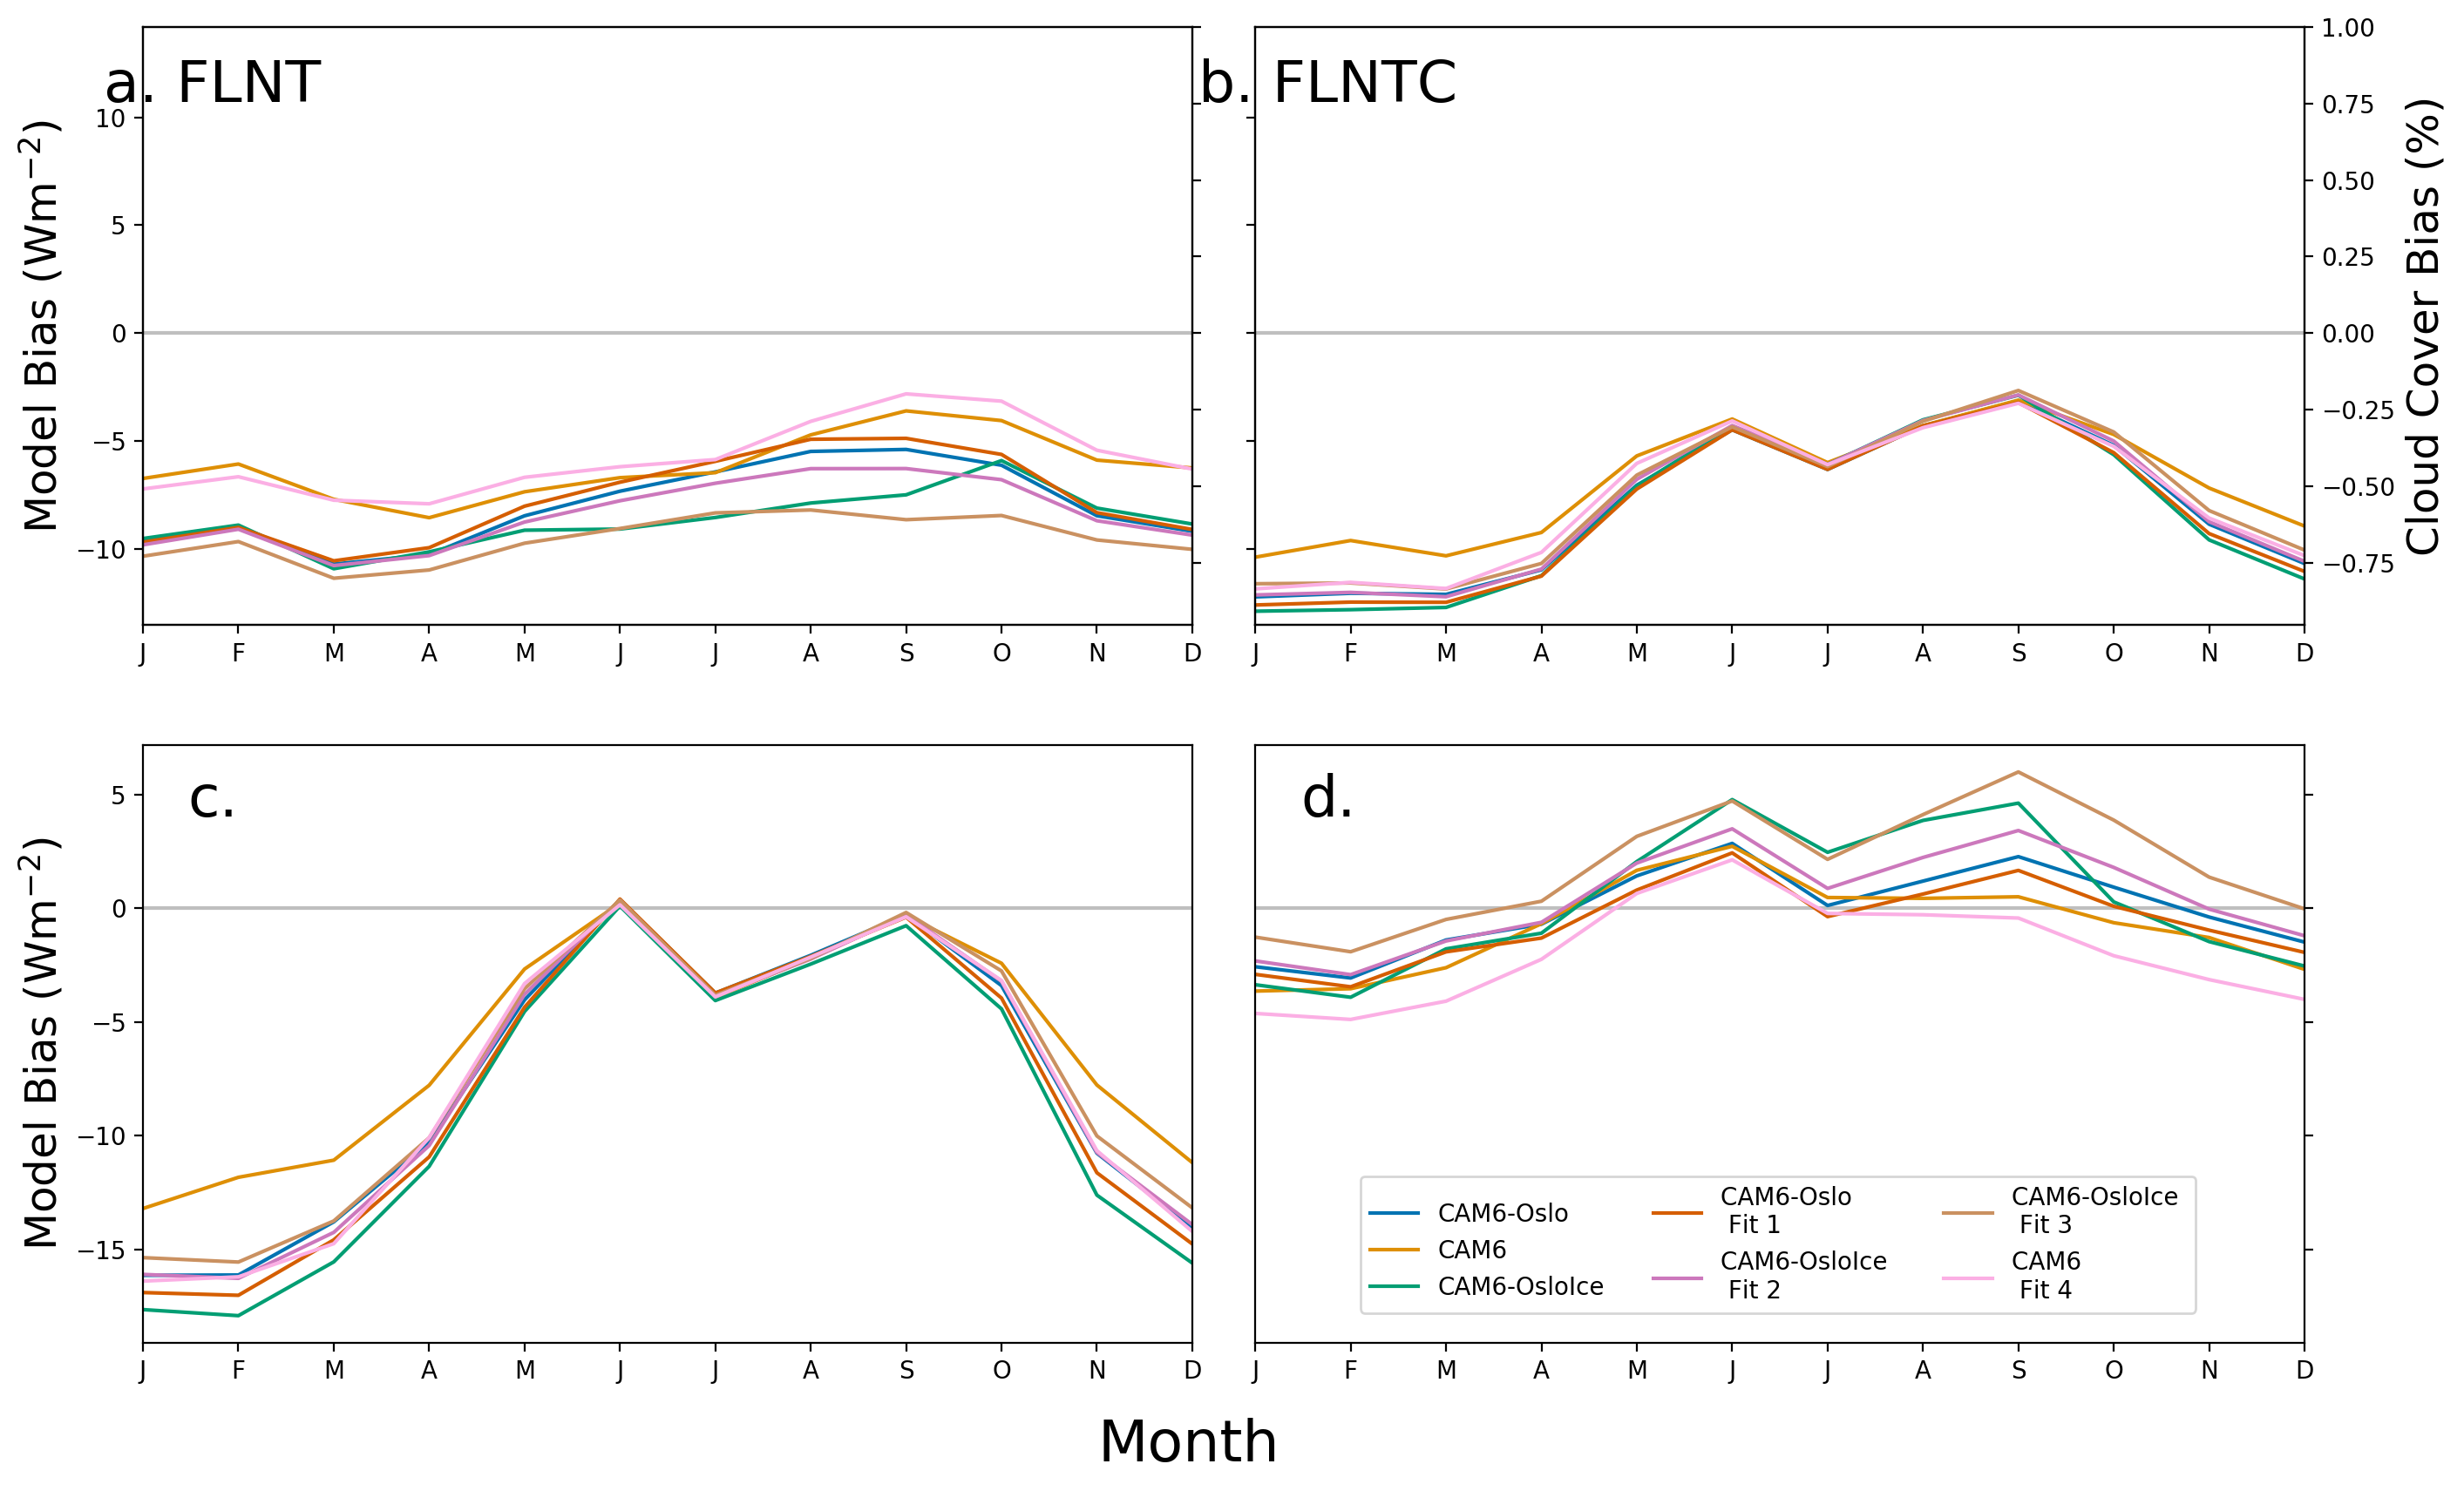

In [16]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(16)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

allcases.plot_months_line('FLNT',ax=axs[0], bias=True,linestyle='solid')
allcases.plot_months_line('FLNTC',ax=axs[1], bias=True,linestyle='solid')
allcases.plot_months_line('FLNSC',ax=axs[2], bias=True,linestyle='solid')
allcases.plot_months_line('LWCF',ax=axs[3], bias=True,linestyle='solid')

ax0b = axs[0].twinx()
ax1b = axs[1].twinx()
# allcases.plot_months_line('CLDTOT_CAL',ax=ax0b, bias=True, linestyle='dashed',alpha=0.5)
# allcases.plot_months_line('CLDTOT_CAL',ax=ax1b, bias=True, linestyle='dashed',alpha=0.5)

# Mute existing labels and draw zero lines
for i in axs:
    mute_ax(i)
    i.hlines(0,1,12, linestyle='solid',color='gray',alpha=0.5)
    i.set_xlim(1,12)
mute_ax(ax0b)
ax0b.set_yticklabels([])
mute_ax(ax1b)
# One legend
# axs[3].legend(loc='best',ncol=3)
axs[3].legend(loc=(0.1,0.05),ncol=3)

axs[0].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
ax1b.set_ylabel(r'Cloud Cover Bias (%)',fontsize=18)
axs[2].set_ylabel(r'Model Bias (Wm$^{-2}$)',fontsize=18)
axs[3].yaxis.tick_right()

align_yaxis(axs[1], ax0b)
ax1b.set_ylim(ax0b.get_ylim())
# Trying Latex formatting
# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

# Re-label
# fig.text(0.1, 0.5, r'Model Bias (Wm$^{-2}$)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.95, 0.7, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=18)
# fig.text(0.93, 0.5, r'Cloud Cover Bias (%)', va='bottom', ha='center', rotation='vertical', 
#          rotation_mode='anchor', fontsize=22)
fig.text(0.5, 0.05, 'Month', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.83, 'a. FLNT', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.83, 'b. FLNTC', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.42, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.55, 0.42, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

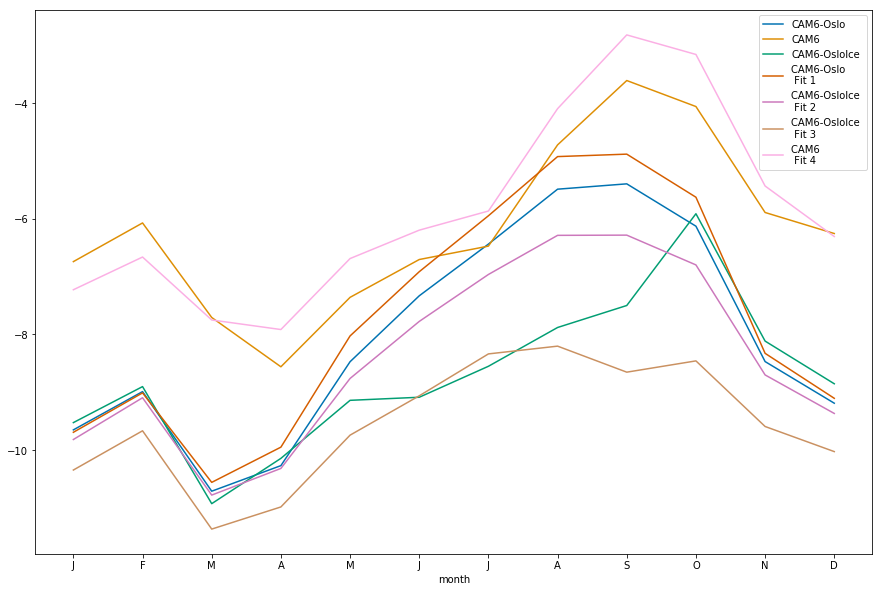

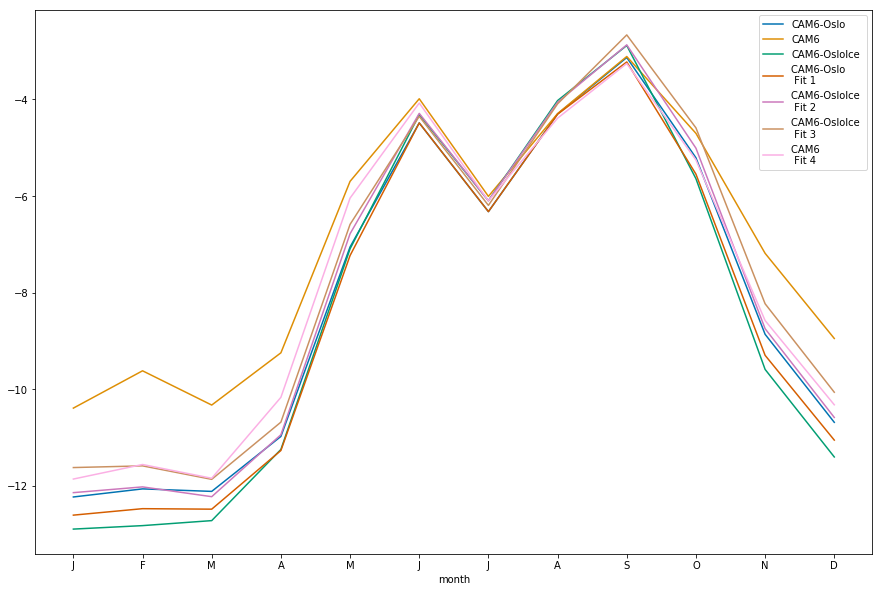

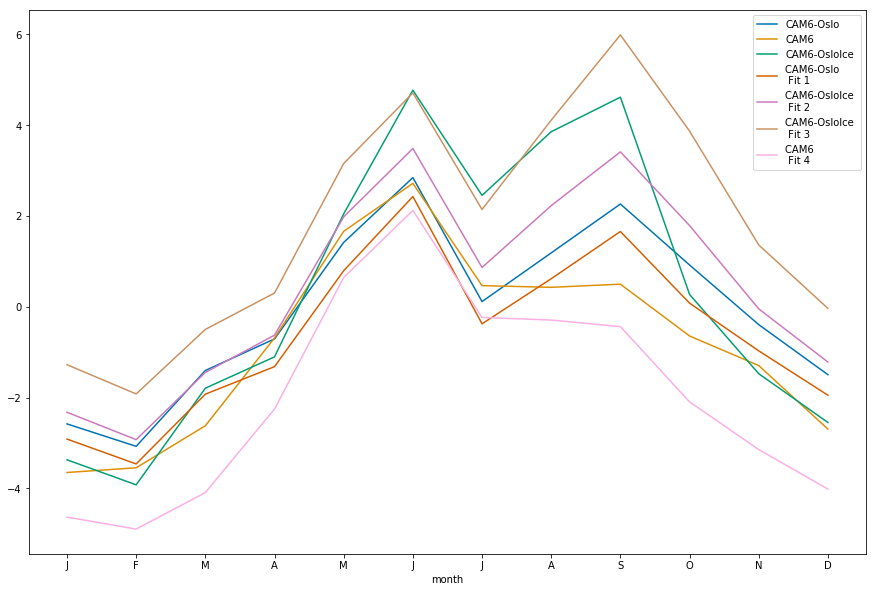

In [47]:
t = allcases.plot_months_line('FLNT', bias=True,linestyle='solid')
t = allcases.plot_months_line('FLNTC', bias=True,linestyle='solid')
t = allcases.plot_months_line('LWCF', bias=True,linestyle='solid')

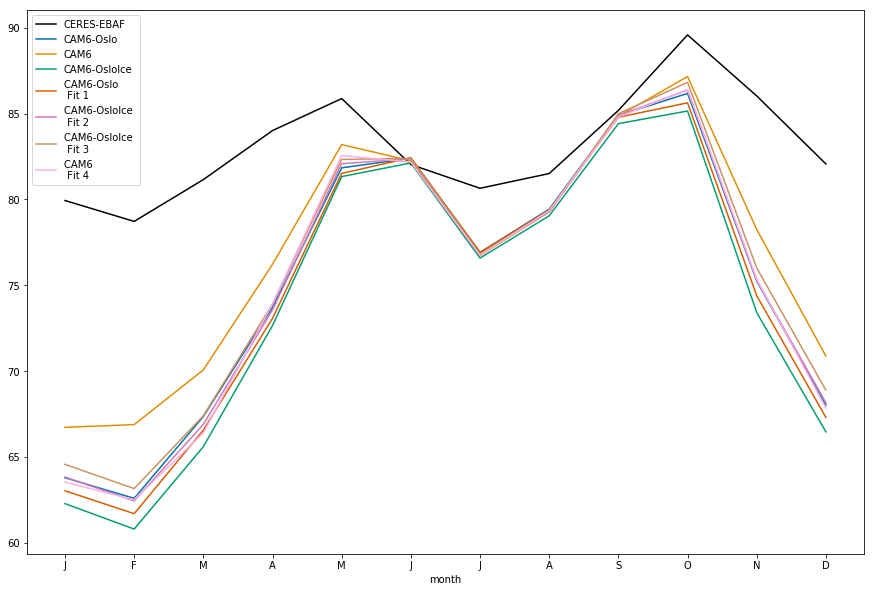

In [18]:
t = allcases.plot_months_line('FLNSC', bias=False,linestyle='solid')
# t = allcases.plot_months_line('FLNT', bias=True,linestyle='solid')

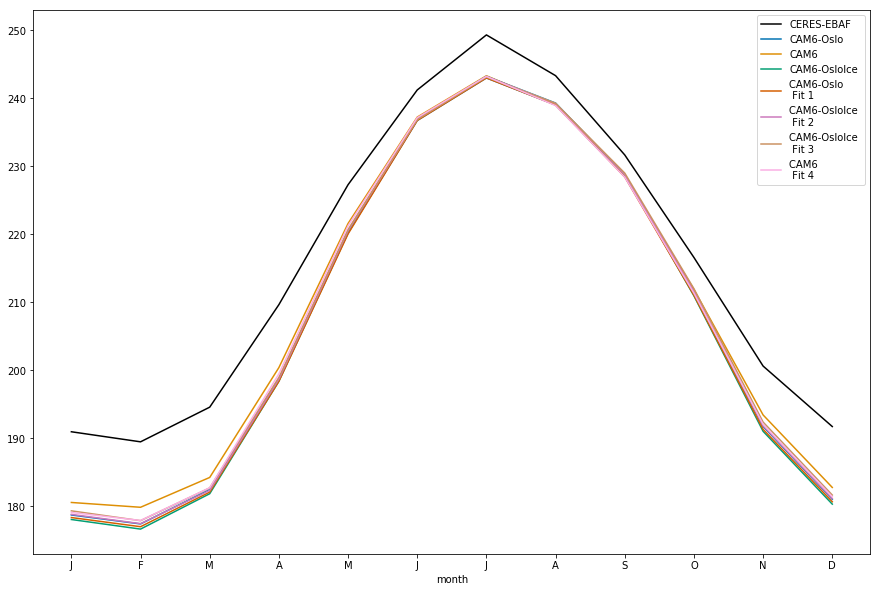

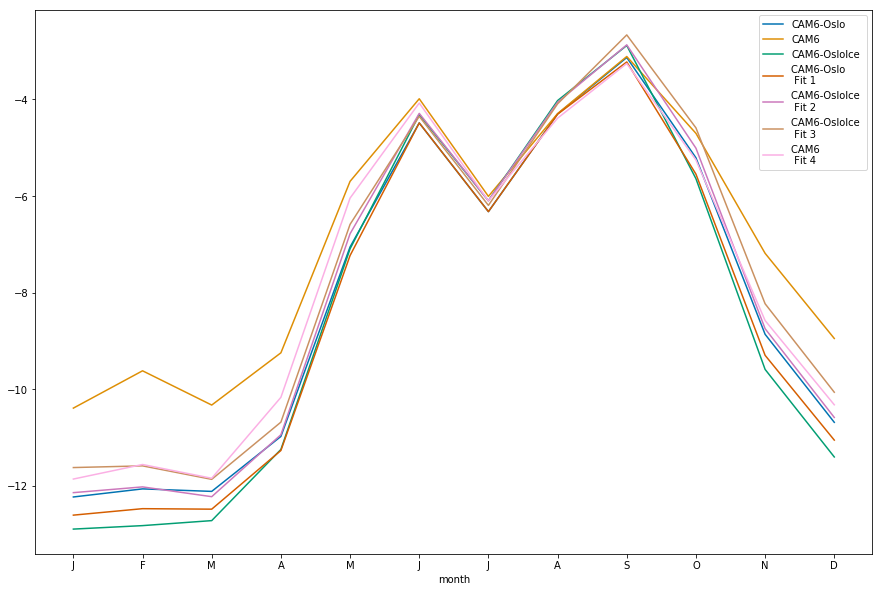

In [46]:
t = allcases.plot_months_line('FLNTC', bias=False,linestyle='solid')
t = allcases.plot_months_line('FLNTC', bias=True,linestyle='solid')

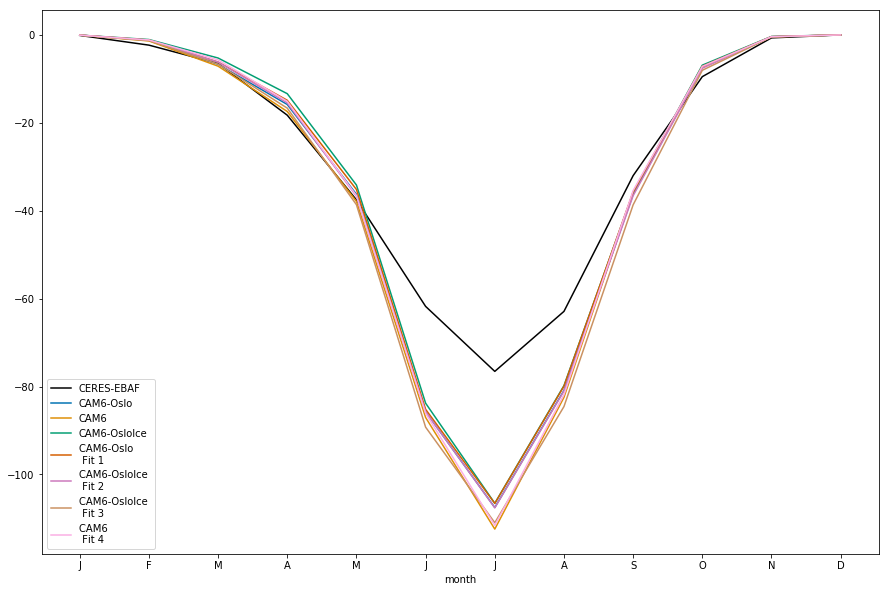

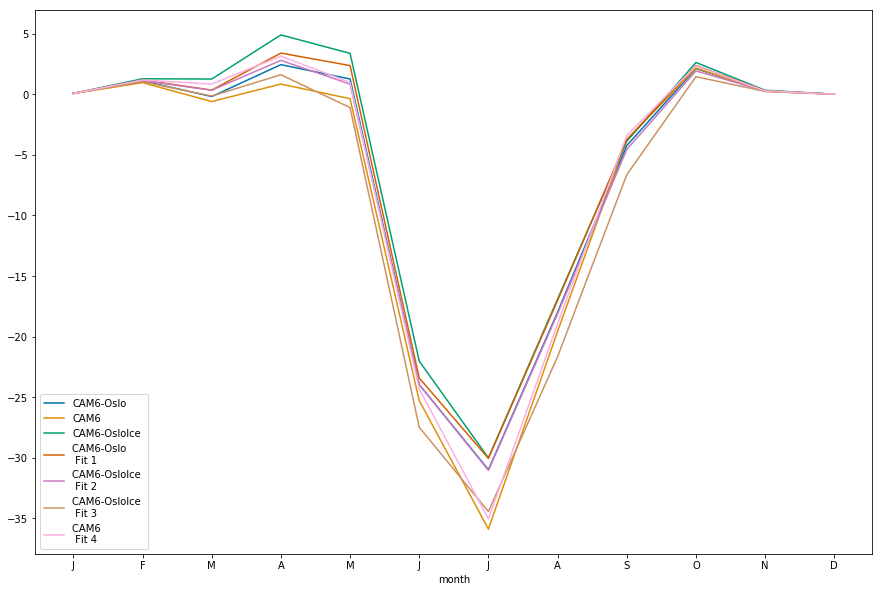

In [37]:
t = allcases.plot_months_line('SWCFS', bias=False,linestyle='solid')
t = allcases.plot_months_line('SWCFS', bias=True,linestyle='solid')

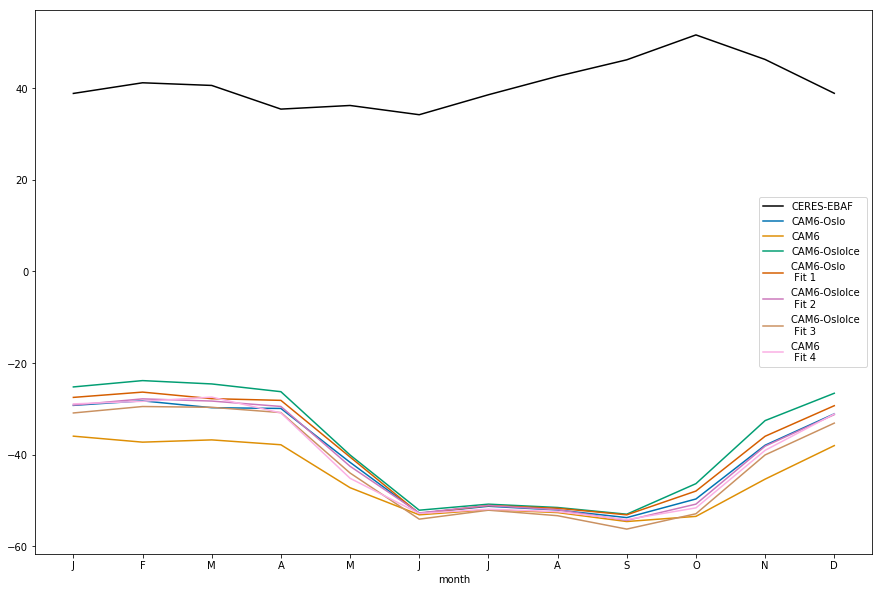

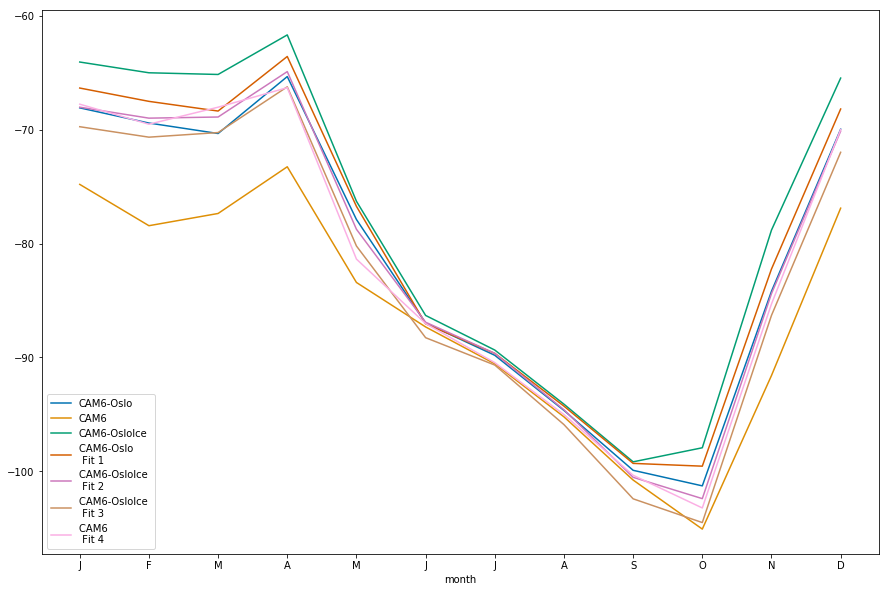

In [40]:
t = allcases.plot_months_line('LWCFS', bias=False,linestyle='solid')
t = allcases.plot_months_line('LWCFS', bias=True,linestyle='solid')

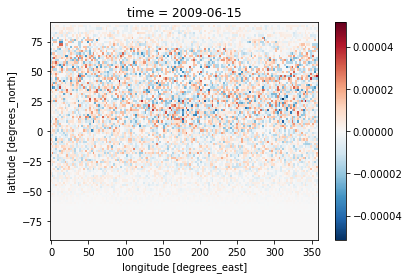

In [30]:
(ceresdata['sfc_cre_net_sw_mon'][0,:,:] + ceresdata['SWCFS'][0,:,:]).plot()

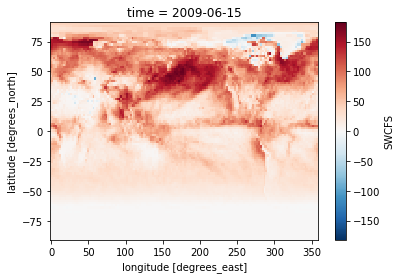

In [29]:
ceresdata['SWCFS'][0,:,:].plot()

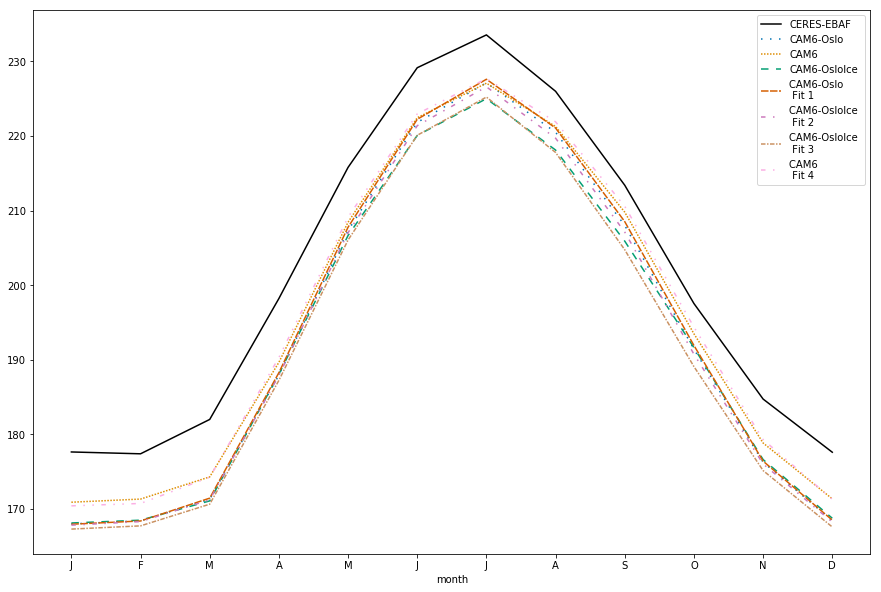

In [11]:
out1 = allcases.plot_months_line('FLNT', bias=False)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


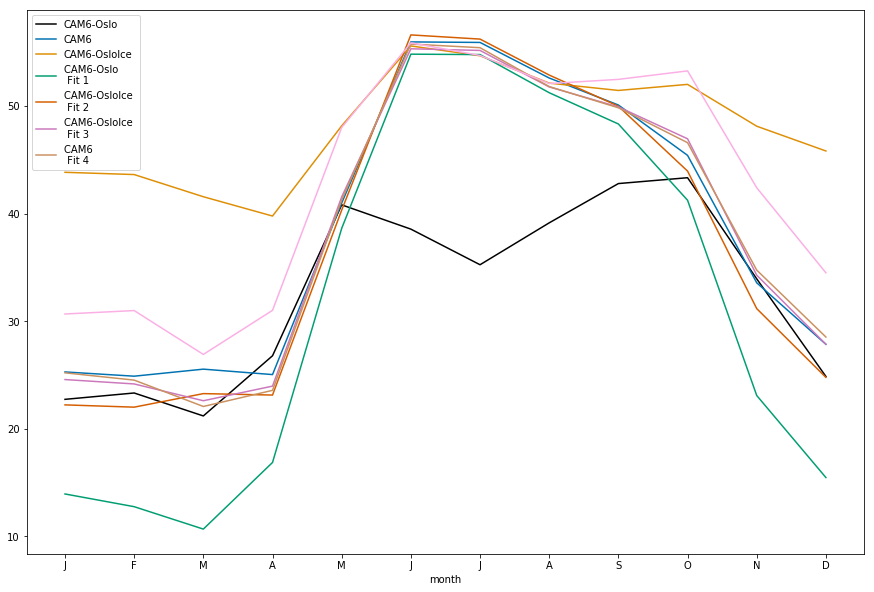

In [50]:
out1 = allcases.plot_months_line('CLDLOW_CAL_LIQ', bias=False)

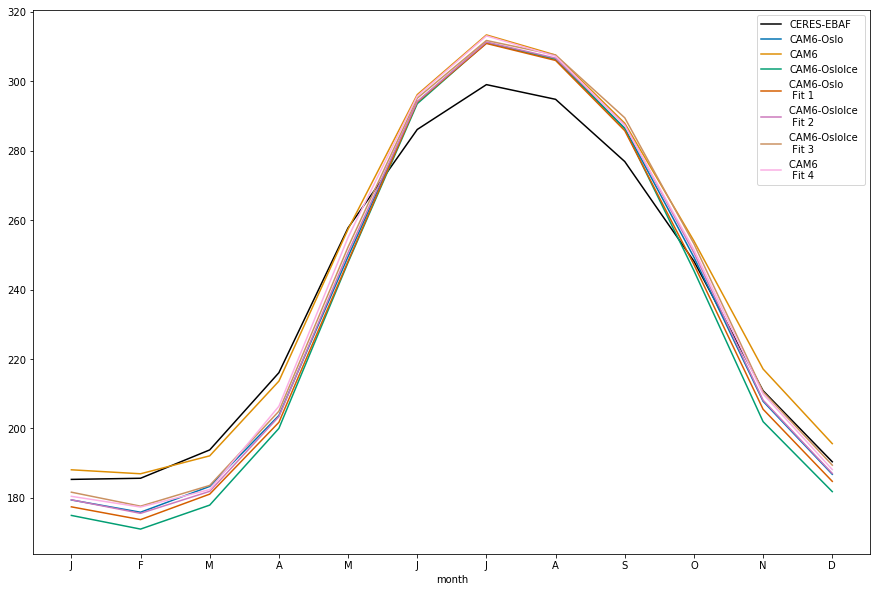

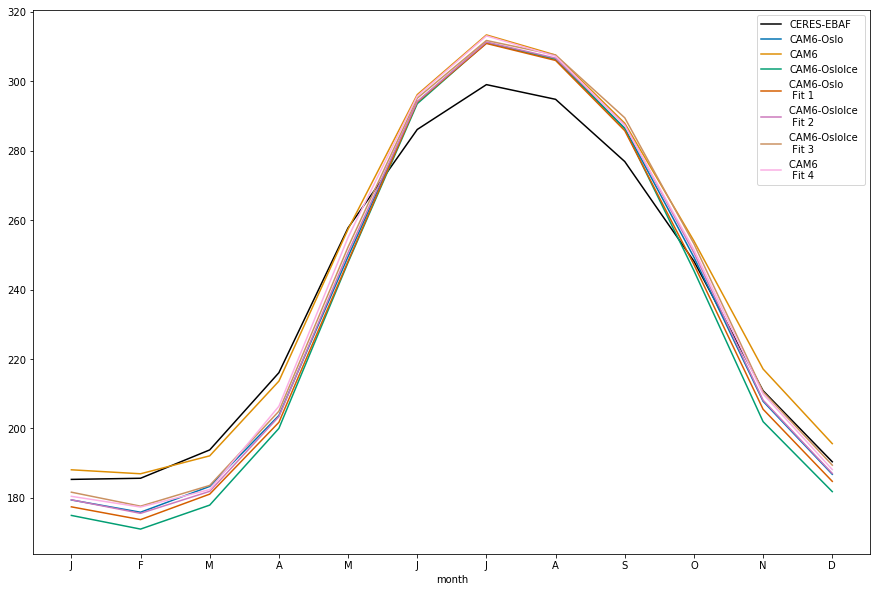

In [54]:
allcases.plot_months_line('FLDS', bias=False)